In [1]:
from __future__ import annotations as _annotations

from dataclasses import dataclass

from pydantic_graph import BaseNode, End, Graph, GraphRunContext


@dataclass
class CountDownState:
    counter: int


@dataclass
class InputGuardrail(BaseNode[CountDownState]):
    async def run(self, ctx: GraphRunContext[CountDownState]) -> CountDown | InputTripwireTriggered:
        # This is the tripwire. Could be a simple check or an 'Agentic' check.
        # We want to make sure the counter is > 0.
        if ctx.state.counter > 0:
            return CountDown()
        else:
            return InputTripwireTriggered()


@dataclass
class InputTripwireTriggered(BaseNode[CountDownState]):
    async def run(self, ctx: GraphRunContext[CountDownState]) -> InputGuardrail:
        # You can involve the user, break the graph, use another Agent, etc.
        ctx.state.counter = int(input(f"'{ctx.state.counter}' is <= 0. Please enter a number >= 0: "))
        return InputGuardrail()


@dataclass
class CountDown(BaseNode[CountDownState]):
    async def run(self, ctx: GraphRunContext[CountDownState]) -> CountDown | OutputGuardrail:
        # Intentionally letting this go below 0 to show the OutputGuardrail.
        if ctx.state.counter < 0:
            return OutputGuardrail()
        ctx.state.counter -= 1
        return CountDown()


@dataclass
class OutputGuardrail(BaseNode[CountDownState, None, int]):
    async def run(self, ctx: GraphRunContext[CountDownState]) -> OutputTripwireTriggered | End[int]:
        # We want the final output to not be < 0.
        if ctx.state.counter < 0:
            return OutputTripwireTriggered()
        return End(ctx.state.counter)


@dataclass
class OutputTripwireTriggered(BaseNode[CountDownState, None, int]):
    async def run(self, ctx: GraphRunContext[CountDownState]) -> End[int]:
        # You can involve the user, break the graph, use another Agent, etc.
        return End(max(ctx.state.counter, 0))


count_down_graph = Graph(
    nodes=[InputGuardrail, InputTripwireTriggered, CountDown, OutputGuardrail, OutputTripwireTriggered],
    auto_instrument=False,
)

# Setting counter to -1 to show the InputGuardrail.
state = CountDownState(counter=-1)
async with count_down_graph.iter(start_node=InputGuardrail(), state=state) as run:
    async for node in run:
        print("Node:", node)
        print(state)
"""
Node: InputTripwireTriggered()
CountDownState(counter=-1)
Node: InputGuardrail()
CountDownState(counter=3)
Node: CountDown()
CountDownState(counter=3)
Node: CountDown()
CountDownState(counter=2)
Node: CountDown()
CountDownState(counter=1)
Node: CountDown()
CountDownState(counter=0)
Node: CountDown()
CountDownState(counter=-1)
Node: OutputGuardrail()
CountDownState(counter=-1)
Node: OutputTripwireTriggered()
CountDownState(counter=-1)
Node: End(data=0)
CountDownState(counter=-1)
"""

Node: InputTripwireTriggered()
CountDownState(counter=-1)
Node: InputGuardrail()
CountDownState(counter=3)
Node: CountDown()
CountDownState(counter=3)
Node: CountDown()
CountDownState(counter=2)
Node: CountDown()
CountDownState(counter=1)
Node: CountDown()
CountDownState(counter=0)
Node: CountDown()
CountDownState(counter=-1)
Node: OutputGuardrail()
CountDownState(counter=-1)
Node: OutputTripwireTriggered()
CountDownState(counter=-1)
Node: End(data=0)
CountDownState(counter=-1)


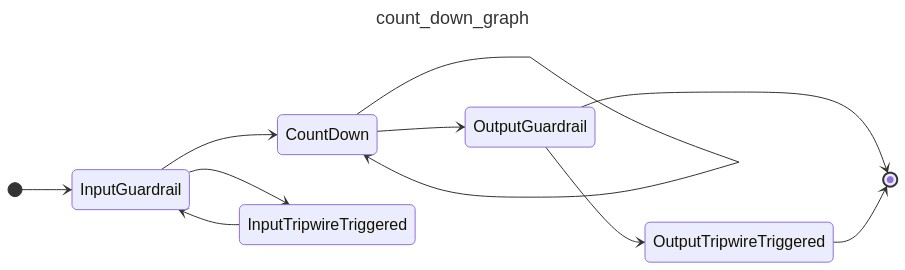

In [ ]:
from IPython.display import Image

Image(count_down_graph.mermaid_image(start_node=InputGuardrail(), direction="LR"))

In [9]:
count_down_graph.mermaid_save(
    "count_down_graph.jpg", start_node=InputGuardrail(), direction="LR", highlighted_nodes=[CountDown]
)